# 0. Preparation


In [1]:
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from skimage.color import rgb2gray
from skimage.transform import resize
import numpy as np
from skimage.feature import hog
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
import onnxruntime as ort
import joblib
from typing import Self

# 1. Dataset Setup

Dataset setup with dummy data. Generate 40 random images of size 128×128 with 3 channels (RGB):

- Class 0 → random noise
- Class 1 → random noise with a bright square in the center


In [2]:
def generate_dummy_images(n_samples=40):
    images = []
    labels = []

    for i in range(n_samples):
        img = np.random.rand(128, 128, 3)

        # Class 1: add a bright square so it has a detectable pattern
        if i % 2 == 0:  # half images = class 1
            img[40:80, 40:80] = 1.0  # white square
            labels.append(1)
        else:
            labels.append(0)

        images.append(img)

    return np.array(images), np.array(labels)


X, y = generate_dummy_images()

# 2. Data Preprocessing


In [3]:
class ImagePreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, size=(64, 64)) -> None:
        self.size = size

    def fit(self, X, y=None) -> Self:
        return self

    def transform(self, X):
        out = []
        for img in X:
            img_resized = resize(img, self.size, anti_aliasing=True)
            img_gray = rgb2gray(img_resized)
            out.append(img_gray)
        return np.array(out)

# 3. Feature Extraction


In [4]:
class HOGExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, pixels_per_cell=(8, 8)) -> None:
        self.pixels_per_cell = pixels_per_cell

    def fit(self, X, y=None) -> Self:
        return self

    def transform(self, X):
        features = []
        for img in X:
            feat = hog(img, pixels_per_cell=self.pixels_per_cell)
            features.append(feat)
        return np.array(features)

# 4. ML Pipeline


In [5]:
pipeline = Pipeline(
    [
        ("preprocess", ImagePreprocessor(size=(64, 64))),
        ("hog", HOGExtractor(pixels_per_cell=(8, 8))),
        ("clf", LogisticRegression(max_iter=300)),
    ]
)

# 5. Data Splitting


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

# 5. ML Training


In [7]:
pipeline.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('hog', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,size,"(64, ...)"
,pixels_per_cell,"(8, ...)"
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True


# 6. ML Evaluation


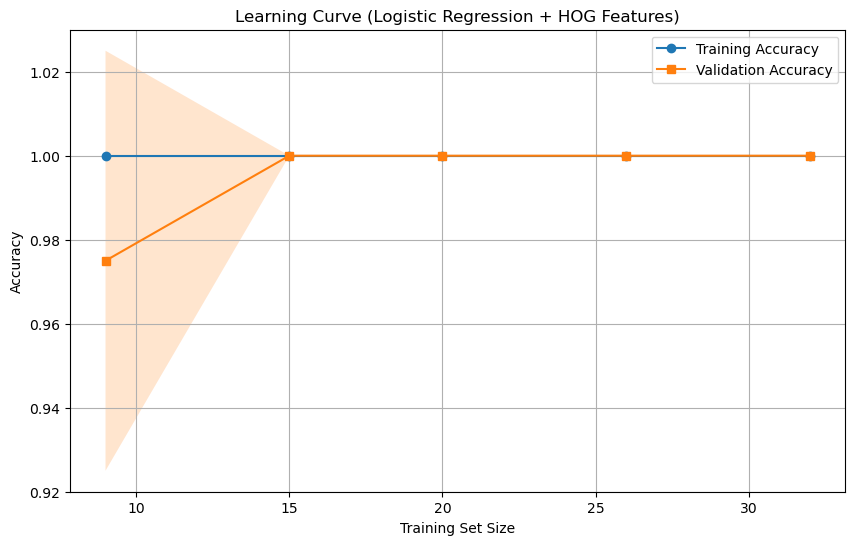

In [8]:
train_sizes, train_scores, val_scores = learning_curve( # type: ignore
    pipeline,
    X, y,
    cv=5,
    train_sizes=np.linspace(0.3, 1.0, 5),
    scoring="accuracy",
    shuffle=True,
    random_state=42
)

train_mean = np.mean(train_scores, axis=1)
train_std  = np.std(train_scores, axis=1)

val_mean = np.mean(val_scores, axis=1)
val_std  = np.std(val_scores, axis=1)


# Plot the learning curve
plt.figure(figsize=(10,6))

plt.plot(train_sizes, train_mean, label="Training Accuracy", marker='o')
plt.plot(train_sizes, val_mean, label="Validation Accuracy", marker='s')

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2)

plt.title("Learning Curve (Logistic Regression + HOG Features)")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.show()

In [9]:
accuracy = pipeline.score(X_test, y_test)
print("Test Accuracy:", accuracy)

Test Accuracy: 1.0


In [10]:
pred = pipeline.predict(X_test[:5])
print("Predictions for first 5 images:", pred)

Predictions for first 5 images: [0 1 0 1 1]


# 7. Save Model


In [11]:
joblib.dump(pipeline, "image_classifier_linreg.pkl")

['image_classifier_linreg.pkl']

# 8. Test the Saved Model

In [12]:
pipeline = joblib.load("image_classifier_linreg.pkl")
print("Model loaded!")
pipeline

Model loaded!


,steps,"[('preprocess', ...), ('hog', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,size,"(64, ...)"
,pixels_per_cell,"(8, ...)"
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True


In [13]:
X_test, y_test = generate_dummy_images(10)

preds = pipeline.predict(X_test)
print(preds)

[1 0 1 0 1 0 1 0 1 0]


# 9. Convert Model to ONNX

## 9.1 Convert Model Pipeline

In [14]:
clf = pipeline.named_steps["clf"]

sample = X_train[0]  # one input image
features = pipeline.named_steps["hog"].transform(
    pipeline.named_steps["preprocess"].transform([sample])
)
print(features.shape)

(1, 2916)


In [15]:
n_features = features.shape[1]  # e.g., 1764

initial_type = [('input', FloatTensorType([None, n_features]))]

onnx_model = convert_sklearn(clf, initial_types=initial_type)

with open("image_classifier_linreg.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString()) # type: ignore

## 9.2 Test ONNX model

In [18]:
session = ort.InferenceSession("image_classifier_linreg.onnx")
input_name = session.get_inputs()[0].name

print("ONNX input name:", input_name)

ONNX input name: input


In [19]:
test_img = X_test[0]

# Apply preprocess
prep = pipeline.named_steps["preprocess"].transform([test_img])

# Apply HOG
hog_feats = pipeline.named_steps["hog"].transform(prep)

print("Feature shape:", hog_feats.shape)

# prediction
inputs = {input_name: hog_feats.astype(np.float32)}
pred = session.run(None, inputs)

print("Prediction:", pred)


Feature shape: (1, 2916)
Prediction: [array([1]), [{0: 0.07353585958480835, 1: 0.9264641404151917}]]
